In [11]:
import pandas as pd, json, re, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


/var/folders/q7/p3s6dfbn0dv04bh3j4kgrz2c0000gn/T/ipykernel_5792/434974609.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=articles_per_source, x="source", y="articles", palette="viridis")


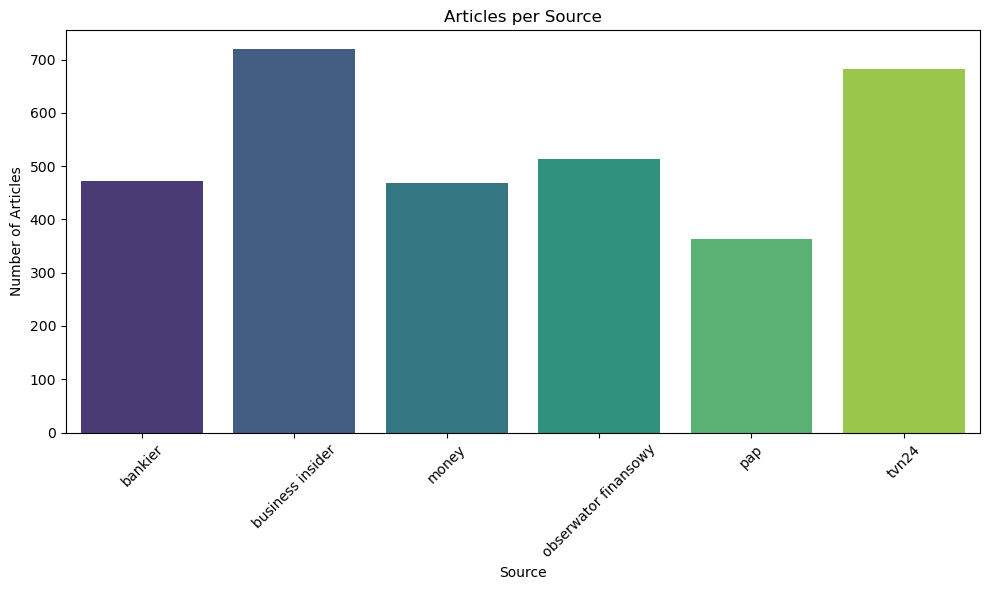

In [14]:
import pandas as pd

files = {
    "bankier": "wyniki LLM/bankier_llm_extracted.csv",
    "business insider": "wyniki LLM/businessinsider_llm_extracted.csv",
    "money": "wyniki LLM/money_llm_extracted.csv",
    "obserwator finansowy": "wyniki LLM/obserwatorfinansowy_llm_extracted_clean.csv",
    "pap": "wyniki LLM/pap_llm_extracted.csv",
    "tvn24": "wyniki LLM/tvn24_llm_extracted.csv"
}

rows = []
for name, path in files.items():
    try:
        df = pd.read_csv(path)
        rows.append({"source": name, "articles": len(df)})
    except Exception as e:
        rows.append({"source": name, "articles": f"ERROR: {e}"})

pd.DataFrame(rows)

articles_per_source = pd.DataFrame(rows)

# Plot the barplot
plt.figure(figsize=(10, 6))
sns.barplot(data=articles_per_source, x="source", y="articles", palette="viridis")
plt.title("Articles per Source")
plt.xlabel("Source")
plt.ylabel("Number of Articles")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [ ]:
# Create a DataFrame for the barplot


In [3]:
# Parse forecasts_json -> normalized long df (one row per variable/year)
def _parse_row(raw: str):
    try:
        items = json.loads(raw)
    except Exception:
        return []
    out = []
    for f in items:
        if not isinstance(f, dict) or "variable" not in f or "value" not in f:
            continue
        var = str(f.get("variable", "")).strip().lower()
        # keep only known macro variables
        if var not in {"gdp","inflation","unemployment","deficit","public_debt","interest_rate","fx","wages","other"}:
            continue
        horizon = str(f.get("horizon", "")).strip()
        m = re.search(r"\b(\d{4})\b", horizon)
        if not m:
            # skip non-annual or unknown horizons
            continue
        year = int(m.group(1))
        # coerce numeric value
        try:
            val = pd.to_numeric(str(f["value"]).replace(",", "."), errors="coerce")
        except Exception:
            val = np.nan
        if pd.isna(val):
            continue
        out.append({
            "variable": var,
            "year": year,
            "value": float(val)
        })
    return out

rows = []
for i, r in df.iterrows():
    recs = _parse_row(r.get("forecasts_json", "[]"))
    for rr in recs:
        rr.update({
            "url": r.get("url"),
            "who": r.get("main_topic") or r.get("title_search") or ""
        })
        rows.append(rr)

forecasts_long = pd.DataFrame(rows)
# keep only key variables to avoid mixing in pivot
key_vars = ["gdp","public_debt","deficit","inflation","unemployment","interest_rate"]
forecasts_long = forecasts_long[forecasts_long["variable"].isin(key_vars)]

# Wide form: separate columns per variable (prevents mixing GDP/Public debt)
forecasts_wide = (forecasts_long
                  .pivot_table(index=["year","who"], columns="variable", values="value", aggfunc="first")
                  .reset_index())

# Example sanity check (no NaN due to mixing):
print(forecasts_wide.loc[forecasts_wide["year"].isin([2022,2023]), ["year","who","gdp","unemployment"]].head(10)) #"public debt"


variable  year                                                who   gdp  \
127       2022  Budżet na 2022 rok i prognozy makroekonomiczne...   4.6   
128       2022  Budżet państwa na 2022 rok i debata w Sejmie d...   4.6   
129       2022  CNB podniosło stopy procentowe; w artykule poj...   NaN   
130       2022  Chińska gospodarka: PKB w 2Q 2022 i prognoza n...   4.0   
131       2022  Decyzja RPP o podwyżce stóp procentowych w Polsce   NaN   
132       2022  Decyzje RPP lipiec 2022 – prognozy dotyczące s...   NaN   
133       2022  Decyzje i prognozy dot. stóp procentowych i in...   NaN   
134       2022  Fitch obniżył prognozy PKB Polski na 2020 i po...   3.3   
135       2022  Gospodarczy wpływ konfliktu Rosja-Ukraina na U... -50.0   
136       2022  IMF prognozuje wzrost PKB globalnie i w wybran...   5.1   

variable  unemployment  
127                5.9  
128                NaN  
129                NaN  
130                NaN  
131                NaN  
132                NaN  

In [4]:
# Load actual values from dane_makroekonomiczne.json (prefer eurostat_gus, else oryginalne)
with open("dane_makroekonomiczne.json", "r", encoding="utf-8") as f:
    actual_raw = json.load(f)

name_map = {
    "gdp": "Realny wzrost PKB (% r/r)",
    "inflation": "Inflacja CPI (średnioroczna, %)",
    "interest_rate": "Stopa referencyjna NBP (średnioroczna, %)",
    "unemployment": "Stopa bezrobocia (BAEL / Eurostat, %)",
    "deficit": "Deficyt sektora GG (% PKB)",
    "public_debt": "Dług publiczny (GG, % PKB)"
}

ind_by_name = {ind["name"]: ind for ind in actual_raw.get("indicators", [])}

actual_rows = []
for var, ind_name in name_map.items():
    ind = ind_by_name.get(ind_name)
    if not ind:
        continue
    for y, vals in ind.get("values", {}).items():
        try:
            year = int(y)
        except Exception:
            continue
        val = vals.get("eurostat_gus")
        if val is None:
            val = vals.get("oryginalne")
        if val is None:
            continue
        actual_rows.append({"variable": var, "year": year, "actual": float(val)})

actual_df = pd.DataFrame(actual_rows)

# Join example to validate alignment for GDP and Public Debt
check = (forecasts_long[forecasts_long["variable"].isin(["gdp","public_debt"])]
         .merge(actual_df[actual_df["variable"].isin(["gdp","public_debt"])], on=["variable","year"], how="left"))

print(check.sort_values(["variable","year"]).head(12))


    variable  year   value                                                url  \
312      gdp  2007   6.500  https://tvn24.pl/biznes/najnowsze/wyzsza-infla...   
313      gdp  2008   5.300  https://tvn24.pl/biznes/najnowsze/wyzsza-infla...   
314      gdp  2009   5.300  https://tvn24.pl/biznes/najnowsze/wyzsza-infla...   
355      gdp  2009   0.400  https://tvn24.pl/biznes/najnowsze/nbp-wieszczy...   
368      gdp  2009   4.800  https://tvn24.pl/biznes/najnowsze/min-finansow...   
356      gdp  2010   1.400  https://tvn24.pl/biznes/najnowsze/nbp-wieszczy...   
357      gdp  2011   3.400  https://tvn24.pl/biznes/najnowsze/nbp-wieszczy...   
182      gdp  2015   0.250          https://tvn24.pl/tagi/niemcy-gospodarka/9   
146      gdp  2017   2.565  https://tvn24.pl/biznes/ze-swiata/wielka-bryta...   
375      gdp  2017   4.300  https://tvn24.pl/biznes/z-kraju,74/polska-rozp...   
11       gdp  2018  12.000  https://tvn24.pl/biznes/pieniadze/na-lokatach-...   
170      gdp  2018   3.800  

## Porównanie prognoz z rzeczywistymi danymi


In [5]:
# Merge forecasts with actuals
comparison = forecasts_long.merge(
    actual_df, 
    on=['variable', 'year'], 
    how='left'
)

# Calculate forecast errors
comparison['error'] = comparison['value'] - comparison['actual']
comparison['abs_error'] = comparison['error'].abs()
comparison['pct_error'] = (comparison['error'] / comparison['actual'] * 100).replace([np.inf, -np.inf], np.nan)
comparison['abs_pct_error'] = comparison['pct_error'].abs()

# Filter only forecasts where we have actual data
comparison_valid = comparison[comparison['actual'].notna()].copy()

print(f"Total forecasts: {len(forecasts_long)}")
print(f"Forecasts with actual data: {len(comparison_valid)}")
print(f"\nYears with actual data: {sorted(comparison_valid['year'].unique())}")
print(f"Variables analyzed: {sorted(comparison_valid['variable'].unique())}")

Total forecasts: 1059
Forecasts with actual data: 584

Years with actual data: [2021, 2022, 2023]
Variables analyzed: ['deficit', 'gdp', 'inflation', 'interest_rate', 'public_debt', 'unemployment']


In [6]:
# Summary statistics by variable
summary_by_var = comparison_valid.groupby('variable').agg({
    'error': ['mean', 'std'],
    'abs_error': ['mean', 'median'],
    'abs_pct_error': ['mean', 'median'],
    'value': 'count'
}).round(2)

summary_by_var.columns = ['Mean Error', 'Std Error', 'MAE', 'Median AE', 'MAPE (%)', 'Median APE (%)', 'N']
print("\n=== Błędy prognoz według zmiennych ===")
print(summary_by_var)


=== Błędy prognoz według zmiennych ===
               Mean Error  Std Error     MAE  Median AE  MAPE (%)  \
variable                                                            
deficit             36.39      55.80   38.40      10.30    749.75   
gdp                 -0.93       5.44    2.23       1.20    690.01   
inflation           -2.04       9.90    4.76       2.50     46.27   
interest_rate       -0.20       5.59    2.22       1.05    163.46   
public_debt        132.68     456.42  136.61       5.60    274.01   
unemployment         1.89       1.39    1.93       2.20     63.47   

               Median APE (%)    N  
variable                            
deficit                203.77   28  
gdp                     47.10  198  
inflation               29.82  205  
interest_rate           21.88  107  
public_debt             11.27   13  
unemployment            70.59   33  


In [7]:
# Summary by year
summary_by_year = comparison_valid.groupby('year').agg({
    'error': ['mean', 'std'],
    'abs_error': 'mean',
    'abs_pct_error': 'mean',
    'value': 'count'
}).round(2)

summary_by_year.columns = ['Mean Error', 'Std Error', 'MAE', 'MAPE (%)', 'N']
print("\n=== Błędy prognoz według roku ===")
print(summary_by_year)


=== Błędy prognoz według roku ===
      Mean Error  Std Error    MAE  MAPE (%)    N
year                                             
2021        0.76      12.16   3.97    181.02  116
2022       -2.19       9.04   4.58     60.78  203
2023        9.59     103.38  11.99    592.11  265


In [8]:
# Detailed comparison for specific variables
key_vars = ['gdp', 'inflation', 'unemployment', 'deficit', 'public_debt']

for var in key_vars:
    var_data = comparison_valid[comparison_valid['variable'] == var].copy()
    if len(var_data) == 0:
        continue
    
    print(f"\n=== {var.upper()} ===")
    print(f"Liczba prognoz: {len(var_data)}")
    print(f"Średni błąd: {var_data['error'].mean():.2f}")
    print(f"Średni błąd bezwzględny (MAE): {var_data['abs_error'].mean():.2f}")
    print(f"Średni błąd procentowy (MAPE): {var_data['abs_pct_error'].mean():.2f}%")
    
    # Show forecasts vs actuals by year
    yearly = var_data.groupby('year').agg({
        'value': ['mean', 'std', 'count'],
        'actual': 'first',
        'error': 'mean'
    }).round(2)
    print("\nPrzy year:")
    print(yearly)


=== GDP ===
Liczba prognoz: 198
Średni błąd: -0.93
Średni błąd bezwzględny (MAE): 2.23
Średni błąd procentowy (MAPE): 690.01%

Przy year:
     value             actual error
      mean   std count  first  mean
year                               
2021  4.72  1.39    53    6.9 -2.18
2022  2.13  8.95    59    5.3 -3.17
2023  1.48  1.71    86    0.1  1.38

=== INFLATION ===
Liczba prognoz: 205
Średni błąd: -2.04
Średni błąd bezwzględny (MAE): 4.76
Średni błąd procentowy (MAPE): 46.27%

Przy year:
      value              actual error
       mean    std count  first  mean
year                                 
2021   6.36  16.07    39    5.1  1.26
2022   9.14   5.17    71   14.4 -5.26
2023  10.42   8.66    95   11.4 -0.98

=== UNEMPLOYMENT ===
Liczba prognoz: 33
Średni błąd: 1.89
Średni błąd bezwzględny (MAE): 1.93
Średni błąd procentowy (MAPE): 63.47%

Przy year:
     value             actual error
      mean   std count  first  mean
year                               
2021  5.98  1.35    

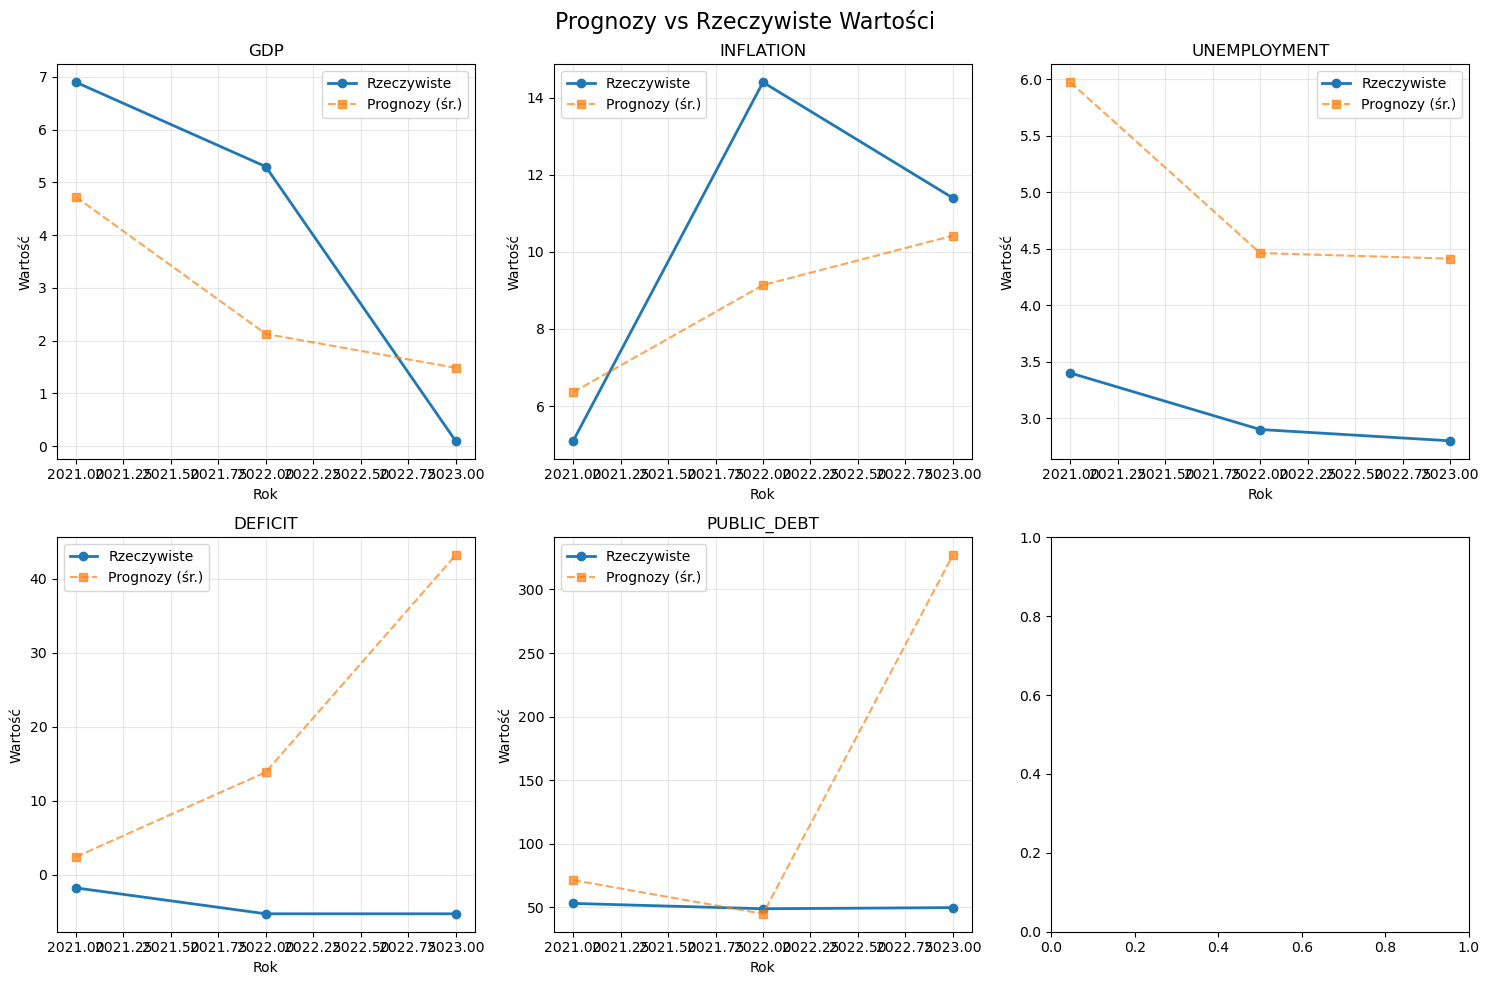

In [9]:
# Visualization: Forecast vs Actual for GDP
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Prognozy vs Rzeczywiste Wartości', fontsize=16)

for idx, var in enumerate(key_vars):
    if idx >= 6:
        break
    ax = axes[idx // 3, idx % 3]
    var_data = comparison_valid[comparison_valid['variable'] == var]
    
    if len(var_data) == 0:
        ax.set_visible(False)
        continue
    
    # Aggregate by year
    yearly_agg = var_data.groupby('year').agg({
        'value': 'mean',
        'actual': 'first'
    })
    
    ax.plot(yearly_agg.index, yearly_agg['actual'], 'o-', label='Rzeczywiste', linewidth=2)
    ax.plot(yearly_agg.index, yearly_agg['value'], 's--', label='Prognozy (śr.)', alpha=0.7)
    ax.set_xlabel('Rok')
    ax.set_ylabel('Wartość')
    ax.set_title(var.upper())
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

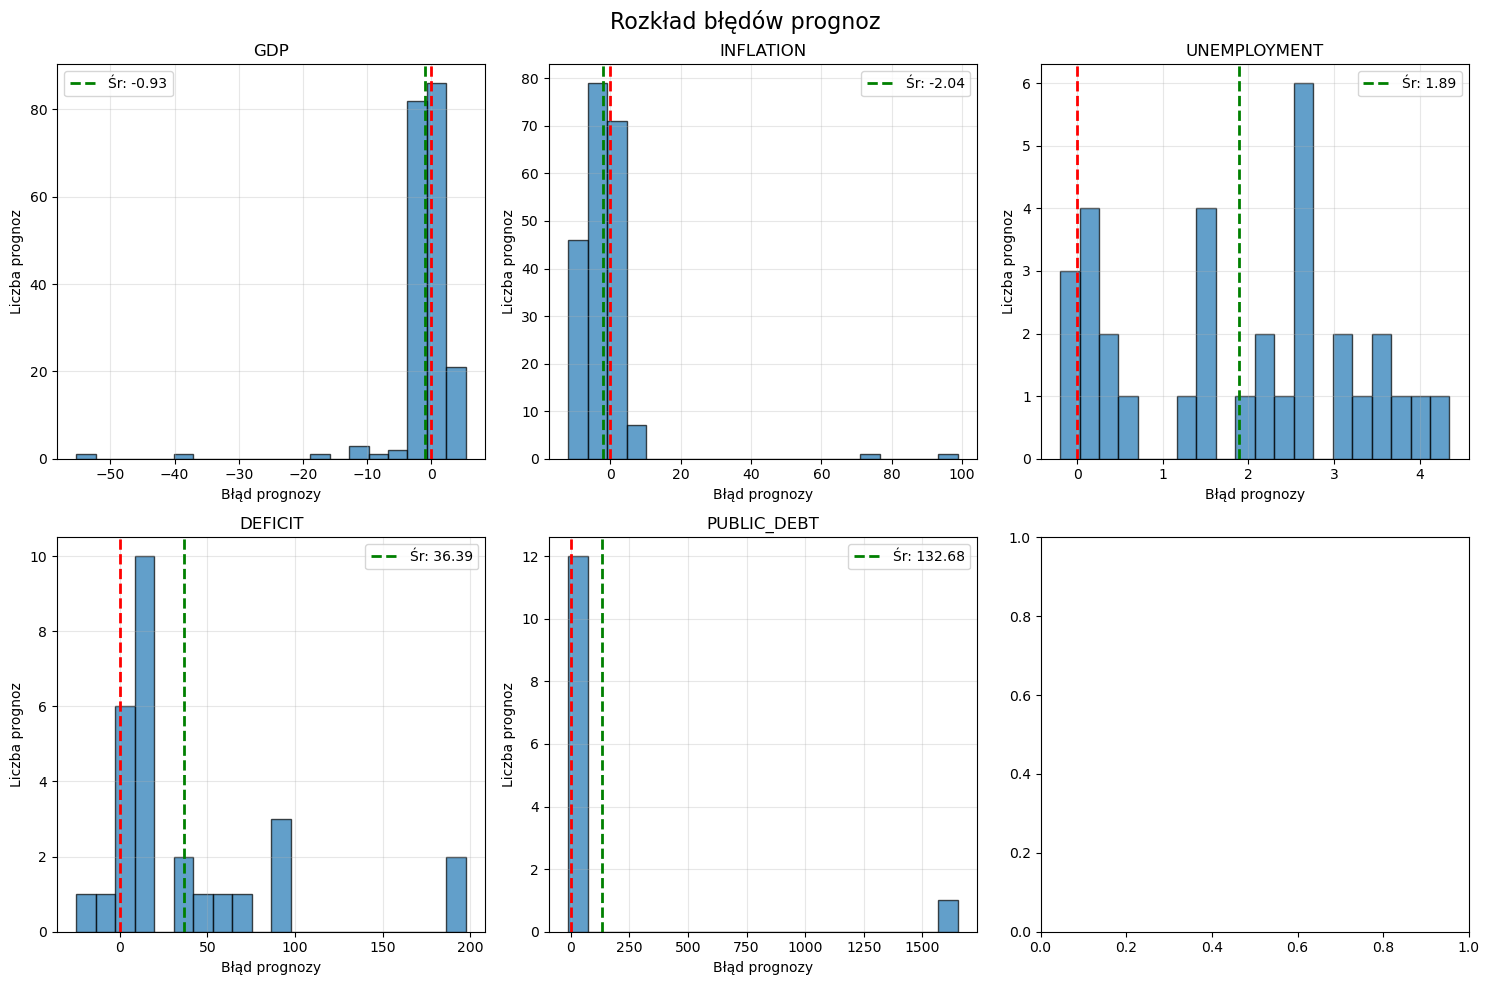

In [10]:
# Visualization: Error distribution
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Rozkład błędów prognoz', fontsize=16)

for idx, var in enumerate(key_vars):
    if idx >= 6:
        break
    ax = axes[idx // 3, idx % 3]
    var_data = comparison_valid[comparison_valid['variable'] == var]
    
    if len(var_data) == 0:
        ax.set_visible(False)
        continue
    
    ax.hist(var_data['error'], bins=20, edgecolor='black', alpha=0.7)
    ax.axvline(0, color='red', linestyle='--', linewidth=2)
    ax.axvline(var_data['error'].mean(), color='green', linestyle='--', linewidth=2, label=f"Śr: {var_data['error'].mean():.2f}")
    ax.set_xlabel('Błąd prognozy')
    ax.set_ylabel('Liczba prognoz')
    ax.set_title(var.upper())
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

----------------------